# M2S13.03: Application of alternative DimRed methods

## 03.1. Library loading

In [12]:
import scanpy as sc
import trimap
import phate
from ivis import Ivis
from sklearn.manifold import MDS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

adata = sc.read_h5ad("02_object_with_hdbscan.h5ad")

## 03.2. DimRed calculations

In [14]:
# Use PCA embeddings as the input; alternatively, use adata.X if preferred
X = adata.obsm['X_pca']

# Compute MDS
# mds = MDS(n_components=2, random_state=42)
# embedding_mds = mds.fit_transform(X)
# adata.obsm['X_mds'] = embedding_mds

# Compute Trimap reduction
tm = trimap.TRIMAP()
embedding_trimap = tm.fit_transform(X)
adata.obsm['X_trimap'] = embedding_trimap

# Compute PHATE reduction
phate_op = phate.PHATE()
embedding_phate = phate_op.fit_transform(X)
adata.obsm['X_phate'] = embedding_phate

# Compute Ivis reduction
model = Ivis(embedding_dims=2, k=15)
embedding_ivis = model.fit_transform(X)
adata.obsm['X_ivis'] = embedding_ivis

Calculating PHATE...
  Running PHATE on 3567 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.31 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.37 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 6.21 seconds.
    Calculating KMeans...
    Calculated KMeans in 9.31 seconds.
  Calculated landmark operator in 15.89 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 25.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.72 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.60 seconds.
Calculated PHATE in 46.68 seconds.
Building KNN index


100%|██████████| 3567/3567 [00:00<00:00, 350927.27it/s]


Extracting KNN neighbours


100%|██████████| 3567/3567 [00:00<00:00, 17734.66it/s]


Training neural network
Epoch 1/1000


2025-03-30 19:05:56.295974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 1s 5ms/step - loss: 0.3327
Epoch 2/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1877
Epoch 3/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1537
Epoch 4/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1421
Epoch 5/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1362
Epoch 6/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1473
Epoch 7/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1262
Epoch 8/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 9/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1225
Epoch 10/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0909
Epoch 11/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1124
Epoch 12/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1055
Epoch 13/1000
28/28 [=================

2025-03-30 19:06:07.791366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [15]:
embeddings = {
    "X_pca": "PCA",
    "X_umap": "UMAP",
    "X_trimap": "Trimap",
    "X_phate": "PHATE",
    "X_ivis": "IVIS"
}

## 03.3. Classical visualization

_Code for this plot was generated using Chat GPT 03-mini-high model_

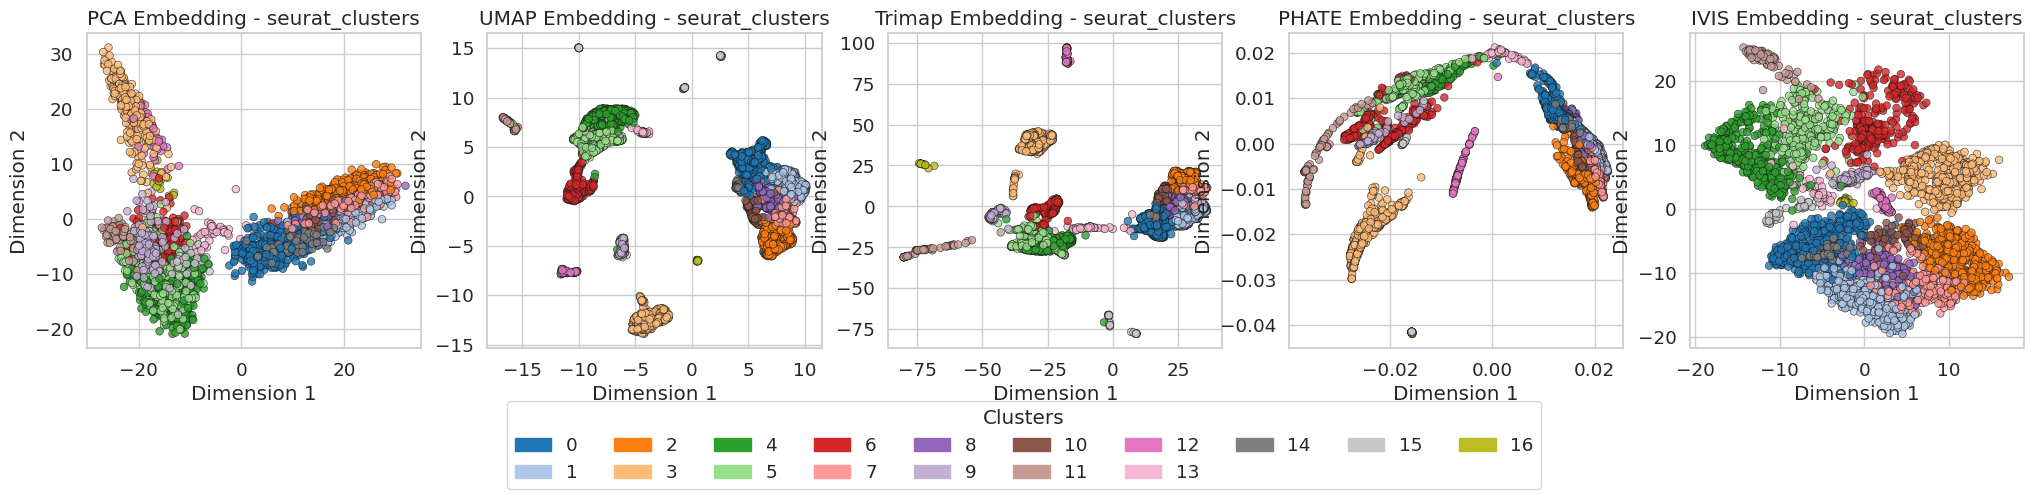

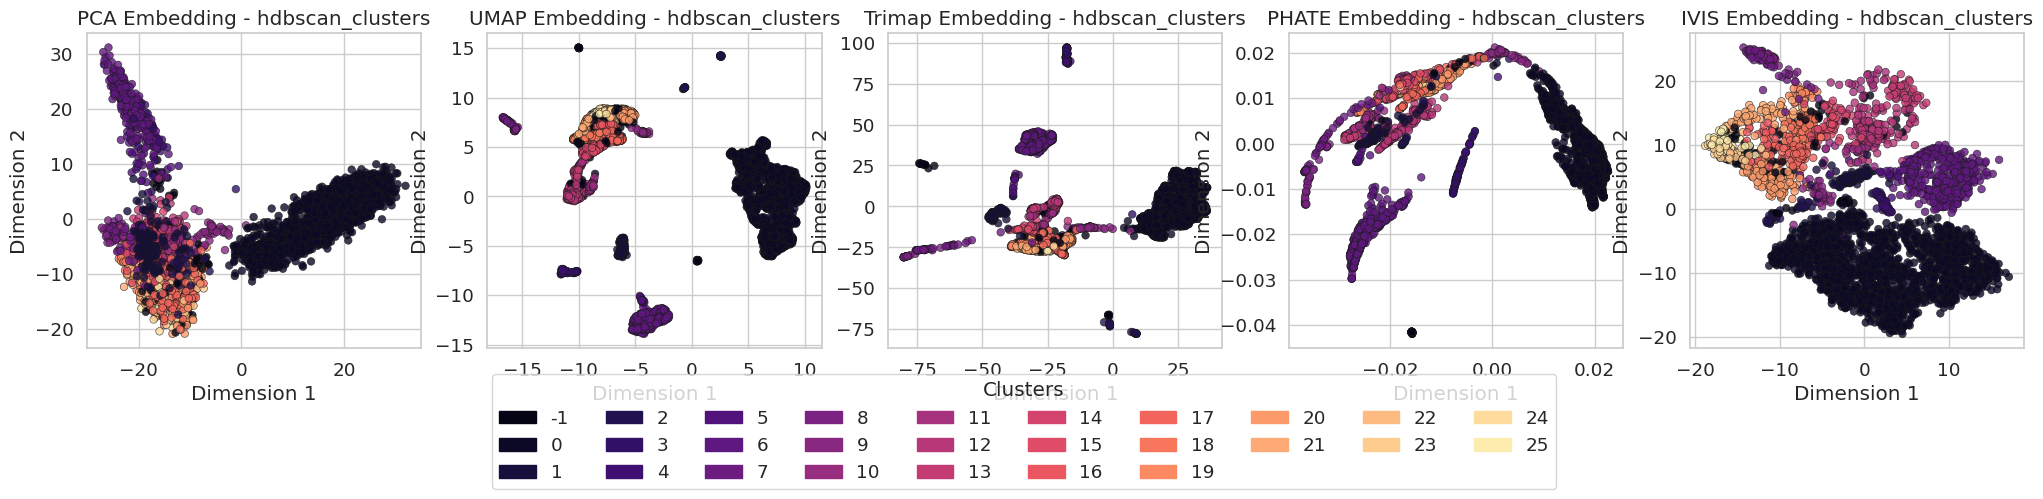

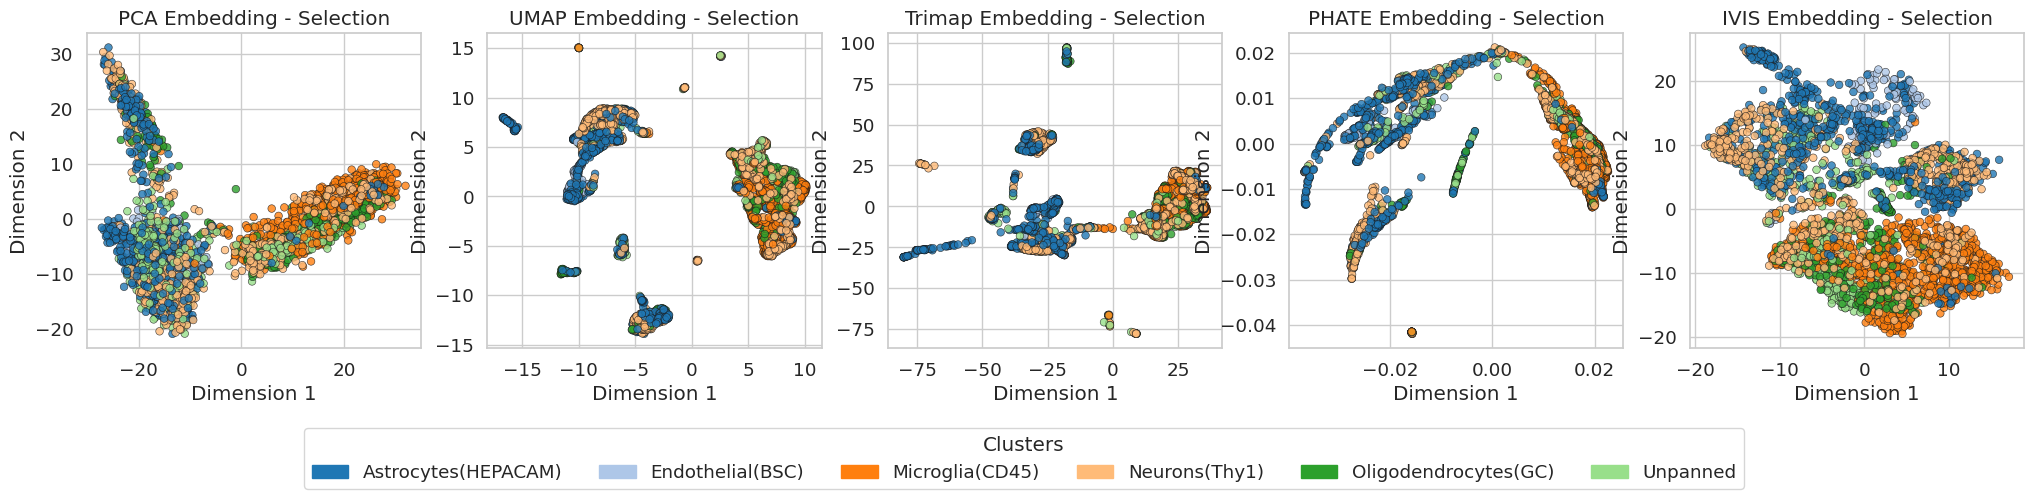

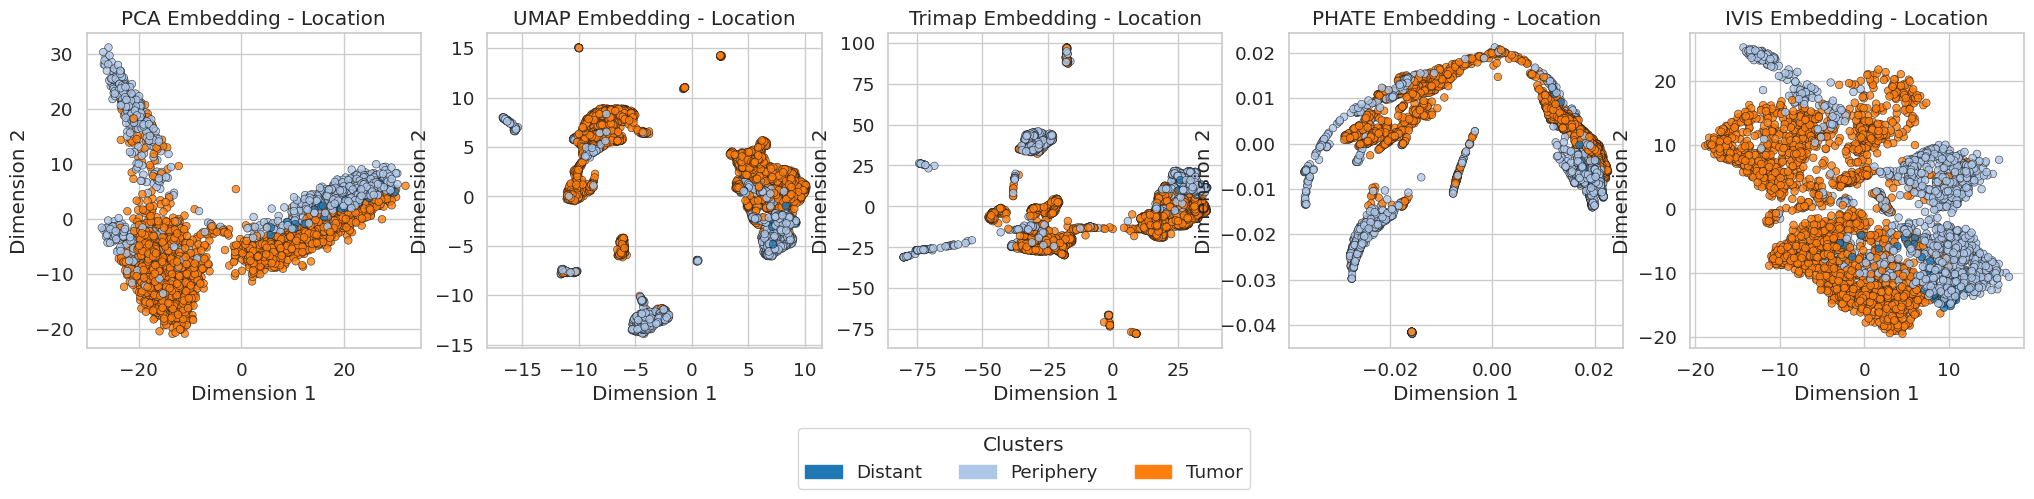

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

sns.set(style="whitegrid", context="notebook", font_scale=1.2)

cluster_cols = ["seurat_clusters", "hdbscan_clusters", "Selection", "Location"] 

for cluster_col in cluster_cols:
    # Sort clusters. If they can all be cast to int, sort numerically; otherwise, sort lexicographically.
    unique_clusters = adata.obs[cluster_col].astype(str).unique()
    try:
        clusters_sorted = sorted(unique_clusters, key=lambda x: int(x))
    except ValueError:
        clusters_sorted = sorted(unique_clusters)
    
    num_clusters = len(clusters_sorted)
    
    # Choose palette: "tab20" if 20 or fewer clusters, otherwise use "magma"
    if num_clusters <= 20:
        palette = sns.color_palette("tab20", num_clusters)
    else:
        palette = sns.color_palette("magma", num_clusters)
    palette_dict = dict(zip(clusters_sorted, palette))
    
    # Create subplots; one subplot per embedding.
    fig, axs = plt.subplots(1, len(embeddings), figsize=(5 * len(embeddings), 5))
    # Ensure axs is iterable if there's only one embedding.
    if not isinstance(axs, (list, np.ndarray)):
        axs = [axs]
    
    for ax, (key, name) in zip(axs, embeddings.items()):
        data = adata.obsm[key]
        data = data[:, :2] if data.shape[1] > 2 else data
        df = pd.DataFrame(data, columns=["Dim1", "Dim2"])
        df[cluster_col] = pd.Categorical(
            adata.obs[cluster_col].astype(str),
            categories=clusters_sorted, ordered=True
        )
        sns.scatterplot(
            data=df, x="Dim1", y="Dim2",
            hue=cluster_col, hue_order=clusters_sorted,
            palette=palette_dict, s=30, edgecolor="k", alpha=0.8, ax=ax, legend=False
        )
        ax.set_title(f"{name} Embedding - {cluster_col}")
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
    
    # Create legend patches; split legend into multiple rows if needed (max 10 columns per row)
    patches = [mpatches.Patch(color=palette_dict[cluster], label=cluster) for cluster in clusters_sorted]
    ncol = min(num_clusters, 10)
    fig.legend(handles=patches, loc="lower center", ncol=ncol,
               bbox_to_anchor=(0.5, -0.05), title="Clusters")
    
    fig.subplots_adjust(bottom=0.25)
    plt.show()


## 03.4. Multidimensional dimensionality reduction visualization (is 3D IMAX better?)

In [17]:
model_3d = Ivis(embedding_dims=3, k=15)
embedding_ivis_3d = model_3d.fit_transform(X)
adata.obsm['X_ivis_3d'] = embedding_ivis_3d

Building KNN index


100%|██████████| 3567/3567 [00:00<00:00, 458661.59it/s]


Extracting KNN neighbours


100%|██████████| 3567/3567 [00:00<00:00, 17761.67it/s]

Training neural network
Epoch 1/1000



2025-03-30 19:12:48.565652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 1s 2ms/step - loss: 0.2977
Epoch 2/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1677
Epoch 3/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1551
Epoch 4/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1330
Epoch 5/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1201
Epoch 6/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.1213
Epoch 7/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0985
Epoch 8/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0948
Epoch 9/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0961
Epoch 10/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0898
Epoch 11/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0866
Epoch 12/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0843
Epoch 13/1000
28/28 [=================

2025-03-30 19:12:56.025495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


_Code for this plot was generated using Chat GPT 03-mini-high model_

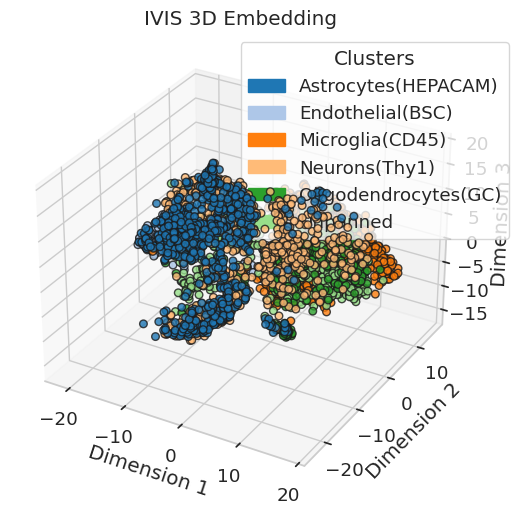

In [18]:
sns.set(style="whitegrid", context="notebook", font_scale=1.2)

cluster_col = "Selection"

clusters_sorted = sorted(adata.obs[cluster_col].astype(str).unique())
num_clusters = len(clusters_sorted)

# Choose palette: "tab20" if 20 or fewer clusters, otherwise use "magma"
if num_clusters <= 20:
    palette = sns.color_palette("tab20", num_clusters)
else:
    palette = sns.color_palette("magma", num_clusters)
palette_dict = dict(zip(clusters_sorted, palette))

# Create figure and 3D axes
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Prepare data from the 3D IVIS embedding
data = adata.obsm['X_ivis_3d']
data = data[:, :3] if data.shape[1] > 3 else data
df = pd.DataFrame(data, columns=["Dim1", "Dim2", "Dim3"])
df[cluster_col] = pd.Categorical(adata.obs[cluster_col].astype(str), categories=clusters_sorted, ordered=True)

# Plot each cluster separately
for cluster in clusters_sorted:
    subset = df[df[cluster_col] == cluster]
    ax.scatter(subset["Dim1"], subset["Dim2"], subset["Dim3"],
               color=palette_dict[cluster], s=30, edgecolor="k", alpha=0.8, label=cluster)

ax.set_title("IVIS 3D Embedding")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")

# Create legend patches
patches = [mpatches.Patch(color=palette_dict[cluster], label=cluster) for cluster in clusters_sorted]
ax.legend(handles=patches, loc="upper right", title="Clusters", bbox_to_anchor=(1.1, 1))

plt.show()

In [19]:
phate_op = phate.PHATE(n_components=3)
embedding_phate = phate_op.fit_transform(X)
adata.obsm['X_phate'] = embedding_phate

Calculating PHATE...
  Running PHATE on 3567 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.28 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.30 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.88 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.31 seconds.
  Calculated landmark operator in 11.53 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 16.65 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.93 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 26.25 seconds.
Calculated PHATE in 56.66 seconds.


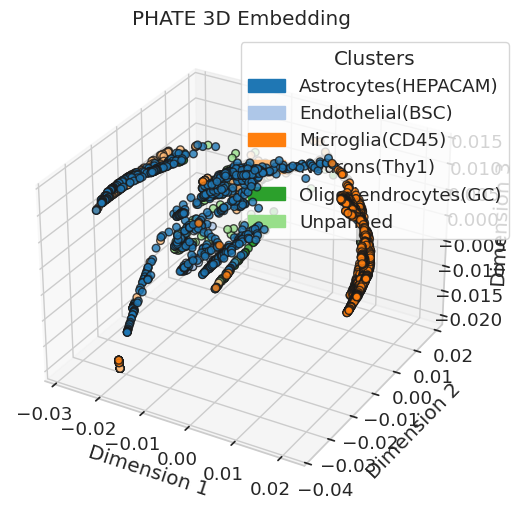

In [20]:
cluster_col = "Selection"

clusters_sorted = sorted(adata.obs[cluster_col].astype(str).unique())
num_clusters = len(clusters_sorted)

# Choose palette: "tab20" if 20 or fewer clusters, otherwise use "magma"
if num_clusters <= 20:
    palette = sns.color_palette("tab20", num_clusters)
else:
    palette = sns.color_palette("magma", num_clusters)
palette_dict = dict(zip(clusters_sorted, palette))

# Create figure and 3D axes
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Prepare data from the 3D PHATE embedding
data = adata.obsm['X_phate']
data = data[:, :3] if data.shape[1] > 3 else data
df = pd.DataFrame(data, columns=["Dim1", "Dim2", "Dim3"])
df[cluster_col] = pd.Categorical(adata.obs[cluster_col].astype(str), categories=clusters_sorted, ordered=True)

# Plot each cluster separately
for cluster in clusters_sorted:
    subset = df[df[cluster_col] == cluster]
    ax.scatter(subset["Dim1"], subset["Dim2"], subset["Dim3"],
               color=palette_dict[cluster], s=30, edgecolor="k", alpha=0.8, label=cluster)

ax.set_title("PHATE 3D Embedding")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")

# Create legend patches
patches = [mpatches.Patch(color=palette_dict[cluster], label=cluster) for cluster in clusters_sorted]
ax.legend(handles=patches, loc="upper right", title="Clusters", bbox_to_anchor=(1.1, 1))

plt.show()

## 03.5. Exporting the new object

In [ ]:
# adata.write("03_object_with_alt_dimreds.h5ad")